Epoch 1/20, Train Loss: 20.6016, Validation Loss: 3.3206
Epoch 2/20, Train Loss: 2.1342, Validation Loss: 1.4217
Epoch 3/20, Train Loss: 1.0853, Validation Loss: 0.8267
Epoch 4/20, Train Loss: 0.7501, Validation Loss: 0.6060
Epoch 5/20, Train Loss: 0.6381, Validation Loss: 0.5411
Epoch 6/20, Train Loss: 0.5989, Validation Loss: 0.5033
Epoch 7/20, Train Loss: 0.5779, Validation Loss: 0.4848
Epoch 8/20, Train Loss: 0.5688, Validation Loss: 0.5025
Epoch 9/20, Train Loss: 0.5604, Validation Loss: 0.4677
Epoch 10/20, Train Loss: 0.5572, Validation Loss: 0.4747
Epoch 11/20, Train Loss: 0.5538, Validation Loss: 0.4735
Epoch 12/20, Train Loss: 0.5572, Validation Loss: 0.4795
Epoch 13/20, Train Loss: 0.5534, Validation Loss: 0.4944
Epoch 14/20, Train Loss: 0.5578, Validation Loss: 0.4774
Epoch 15/20, Train Loss: 0.5501, Validation Loss: 0.4735
Epoch 16/20, Train Loss: 0.5471, Validation Loss: 0.4603
Epoch 17/20, Train Loss: 0.5498, Validation Loss: 0.4783
Epoch 18/20, Train Loss: 0.5531, Valida

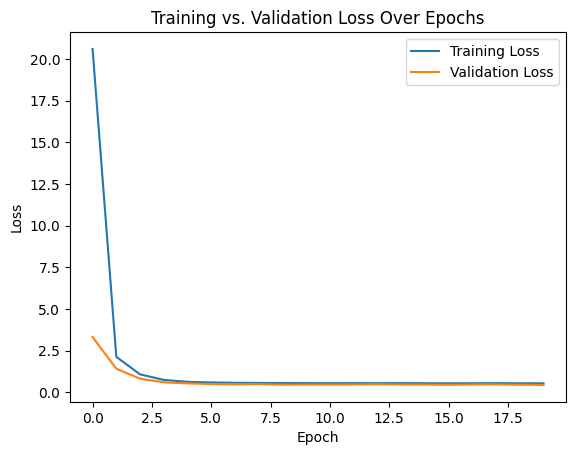

Mean Squared Error: 0.5472
Mean Absolute Error: 0.5696
R²: 0.2934


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, r2_score

# Load and preprocess the White Wine Quality dataset
def load_regression_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
    data = pd.read_csv(url, sep=';')

    X = data.drop("quality", axis=1)
    y = data["quality"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

# Define the PyTorch ANN model for regression
class RegressionANN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionANN, self).__init__()
        self.W1 = torch.nn.Parameter(torch.randn(input_dim, 64) * 0.01)
        self.b1 = torch.nn.Parameter(torch.zeros(64))
        self.W2 = torch.nn.Parameter(torch.randn(64, 32) * 0.01)
        self.b2 = torch.nn.Parameter(torch.zeros(32))
        self.W3 = torch.nn.Parameter(torch.randn(32, 1) * 0.01)
        self.b3 = torch.nn.Parameter(torch.zeros(1))

    def forward(self, x):
        x = torch.matmul(x, self.W1) + self.b1
        x = torch.relu(x)
        x = torch.matmul(x, self.W2) + self.b2
        x = torch.relu(x)
        x = torch.matmul(x, self.W3) + self.b3
        return x

# Train the regression model
def train_regression_model(model, X_train, y_train, X_val, y_val, batch_size, epochs, loss_fn, optimizer):
    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / len(train_dataloader)
        train_losses.append(train_loss)

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        val_loss = val_loss / len(val_dataloader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Evaluate the regression model
def evaluate_regression_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mse_loss = nn.MSELoss()(predictions, y_test)
        mae_loss = mean_absolute_error(y_test.numpy(), predictions.numpy())
        r2 = r2_score(y_test.numpy(), predictions.numpy())

        print(f"Mean Squared Error: {mse_loss.item():.4f}")
        print(f"Mean Absolute Error: {mae_loss:.4f}")
        print(f"R²: {r2:.4f}")

# Visualization
def plot_regression_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs. Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Main script
if __name__ == "__main__":
    # Load data
    X_train, X_test, y_train, y_test = load_regression_data()

    # Split validation set from training set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    # Initialize the model, loss function, and optimizer
    input_dim = X_train.shape[1]
    model = RegressionANN(input_dim=input_dim)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_losses, val_losses = train_regression_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=20, loss_fn=loss_fn, optimizer=optimizer)

    # Plot training and validation loss
    plot_regression_loss(train_losses, val_losses)

    # Evaluate the model
    evaluate_regression_model(model, X_test, y_test)
